# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

## Steps in Multiple Linear Regression
1. Reading, understanding and visualizing the data
2. Preparing the data for modelling (train-test-split, rescaling etc.)
3. Training the model
4. Residual analysis
5. Predictions evaluated on test set

## Step 1: Reading and Understanding the Data

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [183]:
housing = pd.read_csv('Datasets/Housing.csv')

In [184]:
housing.shape

(545, 13)

In [185]:
housing.info()   #housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
price               545 non-null int64
area                545 non-null int64
bedrooms            545 non-null int64
bathrooms           545 non-null int64
stories             545 non-null int64
mainroad            545 non-null object
guestroom           545 non-null object
basement            545 non-null object
hotwaterheating     545 non-null object
airconditioning     545 non-null object
parking             545 non-null int64
prefarea            545 non-null object
furnishingstatus    545 non-null object
dtypes: int64(6), object(7)
memory usage: 55.4+ KB


In [186]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## Step 2: Visualising the Data

This is an important step to identify if `multicollinearity` exists. 
`Multicollinearity` refers to the phenomenon of having related predictor (independent)  variables in the input data set. In simple terms, in a model that has been built using several independent variables, some of these variables might be interrelated, due to which the presence of that variable in the model is redundant. 

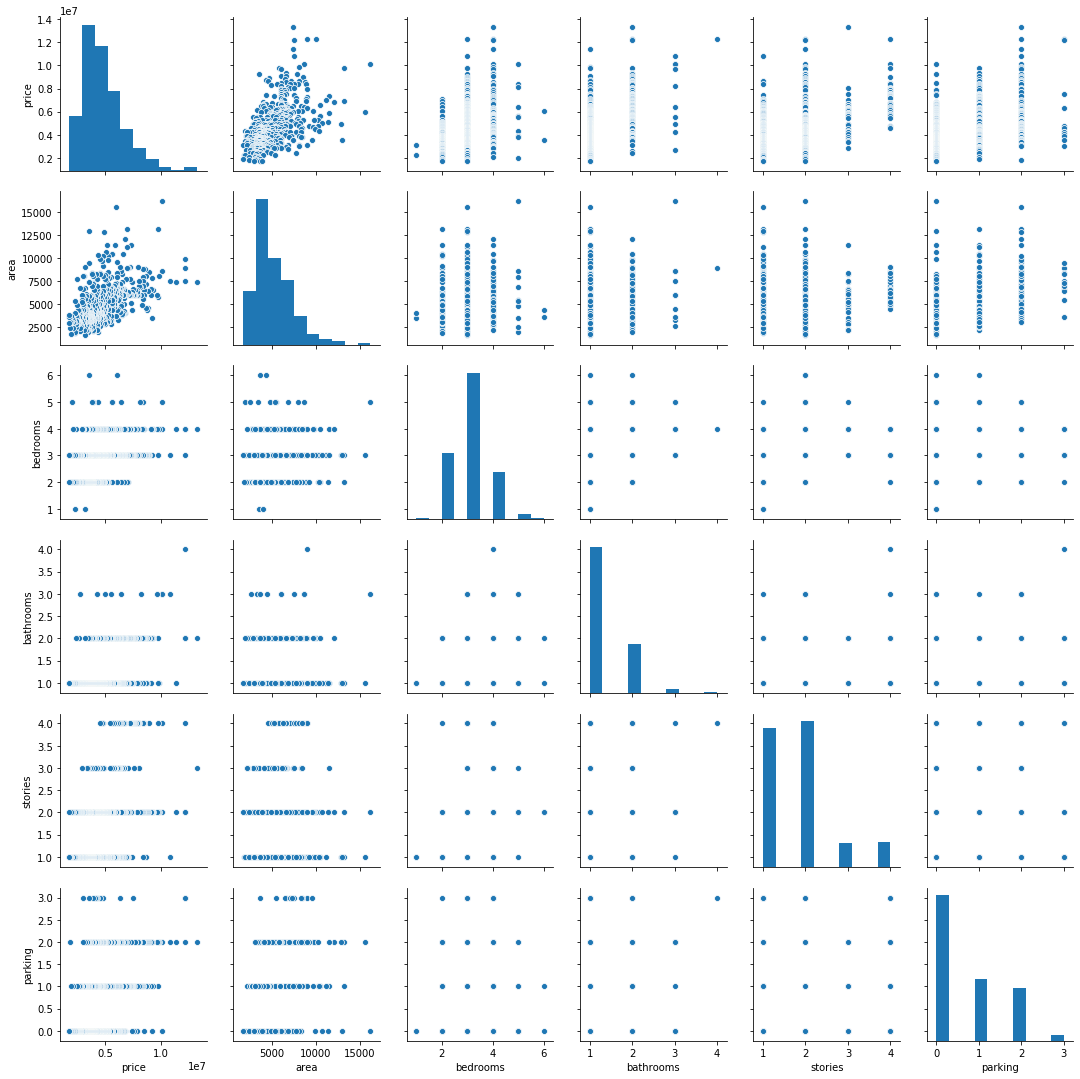

In [187]:
sns.pairplot(housing)

#### Visualising Categorical Variables

Let's make a boxplot for some of these variables.

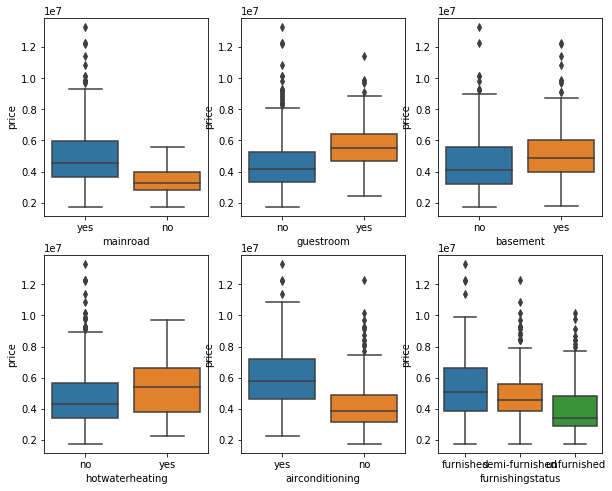

In [188]:
plt.figure(figsize=(10,8))

plt.subplot(2,3,1)            # 2 rows, 3 columns
sns.boxplot(x = 'mainroad', y = 'price', data = housing)
plt.subplot(2,3,2)
sns.boxplot(x = 'guestroom', y = 'price', data = housing)
plt.subplot(2,3,3)
sns.boxplot(x = 'basement', y = 'price', data = housing)
plt.subplot(2,3,4)
sns.boxplot(x = 'hotwaterheating', y = 'price', data = housing)
plt.subplot(2,3,5)
sns.boxplot(x = 'airconditioning', y = 'price', data = housing)
plt.subplot(2,3,6)
sns.boxplot(x = 'furnishingstatus', y = 'price', data = housing)
plt.show()

We can also visualise some of these categorical features parallely by using the `hue` argument. Below is the plot for `furnishingstatus` with `airconditioning` as the hue.

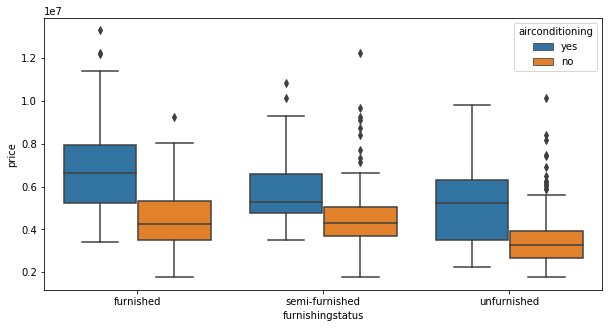

In [189]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'furnishingstatus', y = 'price', hue = 'airconditioning', data = housing)
plt.show()

## Step 3: Data Preparation

- You can see that your dataset has many columns with values as 'Yes' or 'No'.

- But in order to fit a regression line, we would need numerical values and not string. Hence, we need to convert them to 1s and 0s, where 1 is a 'Yes' and 0 is a 'No'.

**Econding**
- converting binary vars to 0/1
- other category vars to dummy

In [190]:
#checking binary variables
housing.mainroad.value_counts()

yes    468
no      77
Name: mainroad, dtype: int64

In [191]:
varlist = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']
housing[varlist]= housing[varlist].apply(lambda x : x.map({'yes':1,'no':0}))

In [192]:
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [193]:
status = pd.get_dummies(housing['furnishingstatus'])
status.head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


Now, you don't need three columns. You can drop the `furnished` column, as the type of furnishing can be identified with just the last two columns where — 
- `00` will correspond to `furnished`
- `01` will correspond to `unfurnished`
- `10` will correspond to `semi-furnished`

In general, if we have `k` levels in a categorical variable then we only need `k-1` dummy columns

In [194]:
# Let's drop the first column from status df using 'drop_first = True'

status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [195]:
housing = pd.concat([housing, status], axis= 1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [196]:
housing = housing.drop('furnishingstatus',axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [197]:
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)

In [198]:
print(df_train.shape)
print(df_test.shape)

(381, 14)
(164, 14)


### Rescaling the Features 

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that except for `area`, all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale. As you know, there are two common ways of rescaling:

1. Min-Max scaling (or normalisation i.e. Between 0 and 1)
    - (x - xmin)/(xmax-xmin)

2. Standardisation (mean-0, sigma-1) 
    - (x-mu)/sigma  where mu= mean, sigma = standard deviation

The advantage of Standardisation over the other is that it doesn't compress the data between a particular range as in Min-Max scaling. This is useful, especially if there is are extreme data point (outlier).

Most of the objects come with three main methods as below -
-  fit() : learns xmax, xmin
- transform() : computes x -xmin/xmax-xmin
- fit_transform() : does both fit and transform

In [199]:
# Instantiate an object

scaler = MinMaxScaler()

#create a list of numeric vars
num_vars=['area','bedrooms','bathrooms','stories','parking','price']

#Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [200]:
df_train.describe() # all the min and max are between 0 and 1 for numeric variables that we transformed

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.260333,0.288710,0.386352,0.136483,0.268591,0.855643,0.170604,0.351706,0.052493,0.299213,0.242345,0.233596,0.414698,0.325459
std,0.157607,0.181420,0.147336,0.237325,0.295001,0.351913,0.376657,0.478131,0.223313,0.458515,0.285933,0.423674,0.493318,0.469162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151515,0.155227,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.221212,0.234424,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.345455,0.398099,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


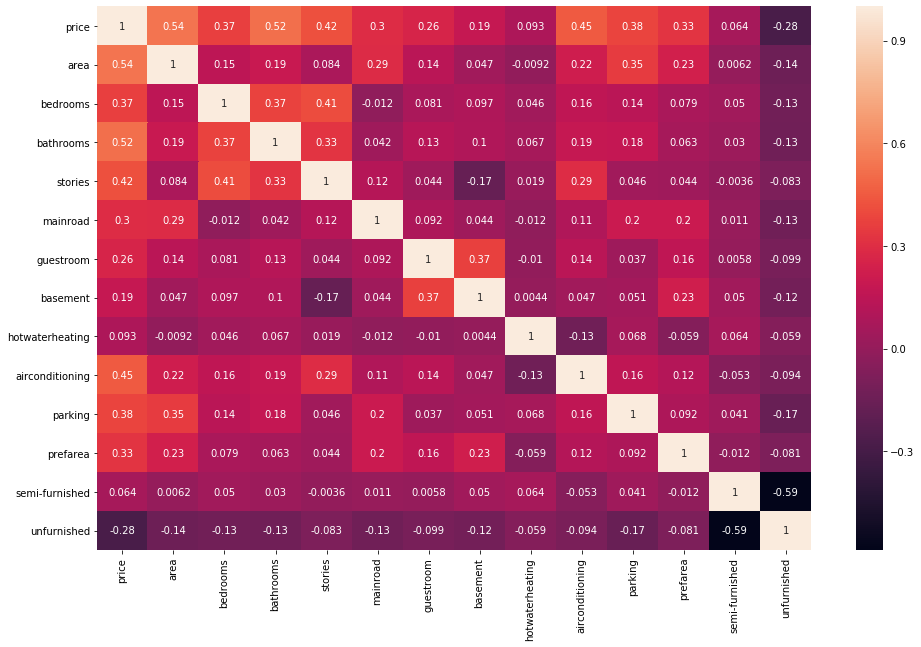

In [201]:
plt.figure(figsize=(16,10))
sns.heatmap(housing.corr(), annot= True)
plt.show()

As you might have noticed, `area` seems to the correlated to `price` the most. Let's see a pairplot for `area` vs `price`.

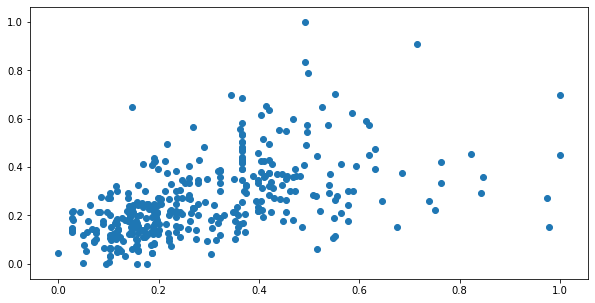

In [202]:
plt.figure(figsize=(10,5))
plt.scatter(df_train.area,df_train.price)
plt.show()

We will follow a bottom-up approach for this, i.e., you will start by building the model with just one variable. So, we pick `area` as the first variable and we'll try to fit a regression line to that.

In [203]:
y_train = df_train.pop('price')
X_train = df_train

In [204]:
y_train.head()
X_train.head()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [205]:
#add a constant
X_train_sm = sm.add_constant(X_train['area'])

# create first model 
lr = sm.OLS(y_train, X_train_sm)

#fit
lr_model= lr.fit()

#Model params
lr_model.params

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const    0.126894
area     0.462192
dtype: float64

In [206]:
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.15e-29
Time:                        19:20:04   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.0

### Adding another variable

The R-squared value obtained is `0.283`. Since we have so many variables, we can clearly do better than this. So let's go ahead and add the second most highly correlated variable, i.e. `bathrooms`.

In [207]:
X_train_sm = X_train[['area', 'bathrooms']]

#add constant
X_train_sm = sm.add_constant(X_train_sm)

#create model
lr = sm.OLS(y_train, X_train_sm)

#fit model
lr_model = lr.fit()

#evaluate parameters
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.51e-54
Time:                        19:20:04   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.0

In [208]:
# Adding another correlated variable 

X_train_sm = X_train[['area', 'bathrooms', 'bedrooms']]

#add constant
X_train_sm = sm.add_constant(X_train_sm)

#create model
lr = sm.OLS(y_train, X_train_sm)

#fit model
lr_model = lr.fit()

#evaluate parameters
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.12e-57
Time:                        19:20:04   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.0

### Adding all the variables to the model

In [209]:
# Check all the columns of the dataframe

housing.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished'],
      dtype='object')

In [210]:
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train, X_train_sm)

lr_model= lr.fit()

print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           8.83e-83
Time:                        19:20:04   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021     

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

Maybe we could drop some?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [211]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,bedrooms,7.33
4,mainroad,6.02
0,area,4.67
3,stories,2.70
11,semi-furnished,2.19
9,parking,2.12
6,basement,2.02
12,unfurnished,1.82
8,airconditioning,1.77
2,bathrooms,1.67


We could have below combinations between `p` value and `VIF`
- High p, High VIF
- High- Low
    - High p, Low VIF *(remove these first)*
    - Low p, High VIF *(remove these after the ones mentioned above)*
- Low p, Low VIF

We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

### Dropping the variable and updating the model

As you can see from the summary and the VIF dataframe, some variables are still insignificant. One of these variables is, `semi-furnished` as it has a very high p-value of `0.938`. Let's go ahead and drop this variables

In [212]:
#Dropping highly correlated variables and insignificant variables
X = X_train.drop('semi-furnished',axis=1)

In [213]:
#add constant
X_train_sm = sm.add_constant(X)

#create model
lr = sm.OLS(y_train, X_train_sm)

#fit model
lr_model = lr.fit()

#evaluate parameters
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.07e-83
Time:                        19:20:04   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019     

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [214]:
# Calculate the VIFs again for the new model

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


### Dropping the Variable and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

As you might have noticed, the variable `bedroom` has a significantly high VIF (`6.6`) and a high p-value (`0.206`) as well. Hence, this variable isn't of much use and should be dropped.

In [215]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('bedrooms', 1)

In [216]:
# Build a second fitted model
X_train_sm = sm.add_constant(X)

#create model
lr = sm.OLS(y_train, X_train_sm)

#fit model
lr_model = lr.fit()

#evaluate parameters
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.73e-84
Time:                        19:20:05   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015     

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [217]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


### Dropping the variable and updating the model

As you might have noticed, dropping `semi-furnised` decreased the VIF of `mainroad` as well such that it is now under 5. 

VIF of 5 = 1/(1-r2)
- this implies that (1-r2) = 0.2
- this implies that r2 = 0.8 which is very high. Hence the variable is highly correlated

But from the summary, we can still see some of them have a high p-value. `basement` for instance, has a p-value of 0.03. We should drop this variable as well.

In [218]:
X= X.drop('basement', axis=1)

In [219]:
# Build a fourth fitted model
X_train_sm = sm.add_constant(X)

#create model
lr = sm.OLS(y_train, X_train_sm)

#fit model
lr_model = lr.fit()

#evaluate parameters
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     77.18
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.13e-84
Time:                        19:20:05   Log-Likelihood:                 378.51
No. Observations:                 381   AIC:                            -735.0
Df Residuals:                     370   BIC:                            -691.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0428      0.014     

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [220]:
# Calculate the VIFs again for the new model
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,mainroad,4.55
0,area,4.54
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
9,unfurnished,1.33
4,guestroom,1.30
5,hotwaterheating,1.12


Now as you can see, the VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model only.

## Step 7: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [221]:
y_train_pred = lr_model.predict(X_train_sm)

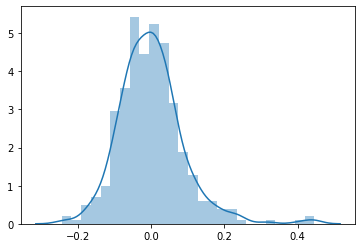

In [222]:
res= y_train - y_train_pred
sns.distplot(res)

## Step 8: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [223]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']

df_test[num_vars] = scaler.transform(df_test[num_vars])  # we use transform instead of fit_transform becasue our mdoel should have already learned this from training dataset

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [224]:
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.229697,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.484848,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.303030,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.242424,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.227879,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


#### Dividing into X_test and y_test

In [225]:
y_test = df_test.pop('price')
X_test = df_test

In [226]:
# Adding constant variable to test dataframe
X_test_sm = sm.add_constant(X_test)

C:\Users\aaladdha\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [227]:
# Creating X_test_sm dataframe by dropping variables from X_test_sm

X_test_sm = X_test_sm.drop(["bedrooms", "semi-furnished", "basement"], axis = 1)

In [228]:
# Making predictions using the final model

y_pred_test = lr_model.predict(X_test_sm)

## Step 9: Model Evaluation

Let's now plot the graph for actual versus predicted values.

In [229]:
r2_score(y_test, y_pred_test)

0.6601344030219641


We can see that the equation of our best fitted line is:

$ price = 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $
